# Chemical Space Visualization and Similarity of Candidate Structures

In [53]:
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)


import pathlib
import os
import copy
from numbers import Number
from itertools import cycle

import pandas as pd
import numpy as np

import umap.umap_ as umap
import umap.plot

import matplotlib.pyplot as plt
import seaborn as sns 
from IPython.display import SVG

import rdkit
from rdkit import Chem, rdBase, RDLogger, DataStructs
RDLogger.DisableLog('rdApp.*')
from rdkit.Chem import AllChem, Draw, inchi, rdDepictor, PandasTools, SaltRemover
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.Chem.MolStandardize import rdMolStandardize

#### Functions Used for Dataset Cleaning

Reading in the dataset and removing chemicals with molecular weights below 50 Da and chemicals that do not contain any carbon atoms

In [249]:
data = pd.read_csv('path/to/the/dataset')

# Assuming that SMILES notations are given in column SMILES
PandasTools.AddMoleculeColumnToFrame(data, 'SMILES', 'ROMol')
data['MW'] = data.ROMol.apply(lambda x: Descriptors.ExactMolWt(x))
data = data[data.MW >= 50].reset_index(drop=True)

In [250]:
def contains_carbon(mol):
    try:
        atomic_no = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
        return bool(6 in atomic_no)
    except:
        return np.nan

data['contains_carbon'] = data.ROMol.apply(lambda x: contains_carbon(x))
data = data[data.contains_carbon == True].reset_index(drop=True)

Removing the isotope labeling of the atoms

In [252]:
def MolWithoutIsotopesToSmiles(mol):
  atom_data = [(atom, atom.GetIsotope()) for atom in mol.GetAtoms()]
  for atom, isotope in atom_data:
      if isotope:
          atom.SetIsotope(0)
  return mol

data['ROMol'] = data.ROMol.apply(lambda x: MolWithoutIsotopesToSmiles(x))

Identifying disconnected structures, eliminating inorganic ions and solvent molecules, and neutralizing remaining ions, while also removing information about stereochemistry

In [ ]:
def remove_ions(mol, ions):
  remover = SaltRemover.SaltRemover(defnData=ions)
  return remover.StripMol(mol)

parts2remove = ['[F,Cl,Br,I]', '[Na,Mg,K,Ca,Li,Ba]', 'CC(=O)O', '[O,N]', 'CS(=O)(=O)O', 'O=S(=O)(O)O', 'O=[N+]([O-])O', 'O=S(=O)(O)CCO',
                'F[P-](F)(F)(F)(F)F' 'O=S(=O)([O-])C(F)(F)F', 'F[B-](F)(F)F', ...]

for part in parts2remove:
  data['ROMol'] = data.ROMol.apply(lambda x: remove_ions(x, part))

In [254]:
uncharger = rdMolStandardize.Uncharger()  # neutralize the molecule (if possible)
data['ROMol'] = data.ROMol.apply(lambda x: uncharger.uncharge(x))

def neutralize_atoms(mol):
    try:
        pattern = Chem.MolFromSmarts("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
        at_matches = mol.GetSubstructMatches(pattern)
        at_matches_list = [y[0] for y in at_matches]
        if len(at_matches_list) > 0:
            for at_idx in at_matches_list:
                atom = mol.GetAtomWithIdx(at_idx)
                chg = atom.GetFormalCharge()
                hcount = atom.GetTotalNumHs()
                atom.SetFormalCharge(0)
                atom.SetNumExplicitHs(hcount - chg)
                atom.UpdatePropertyCache()
        return mol
    except:
        return mol

data['ROMol'] = data.ROMol.apply(lambda x: neutralize_atoms(x))
data.ROMol.apply(lambda x: Chem.RemoveStereochemistry(x)) 
data['SMILES'] = data.ROMol.apply(lambda x: Chem.MolToSmiles(x))
data['InChIKey'] = data.ROMol.apply(lambda x: inchi.MolToInchiKey(x))
data['InChIKey14'] = data.InChIKey.apply(lambda x: x.split('-')[0])



...
# After deduplicating and excluding chemicals unsuitable for LC/HRMS ESI(+) analysis, save the cleaned dataset.
data.to_csv('path/to/output/file', sep='\t', index=False, quoting=False)

#### Uniform Manifold Approximation and Projection (UMAP) Embeddings

After cleaning the datasets, the [Nextflow workflow](https://github.com/idarahu/SMILES2SIRIUS_fp) was used to calculate the SIRIUS+CSI:FingerID positive mode fingerprints for all chemicals in the following datasets:
- PubChemLite (version 0.3.0)
- MassBank Europe (version 2023.11) ESI+ HRMS
- SIRIUS+CSI:FingerID positive mode training data
- Positive mode RTI model training data
- CCSbase training data
- obtained candidate list

The calculated fingerprints of chemicals in the PubChemLite dataset were then used to learn the UMAP embedding.

In [ ]:
# Reading in the data and learning the UMAP embedding
chemspace_pubchem = pd.read_csv('path/to/file/that/contains/SIRIUS+CSI:FingerID/fingerprints/for/chemicals/in/PubChemLite', sep='\t')
mapper5050 = umap.UMAP(n_neighbors=50, min_dist=0.5, random_state=42).fit(chemspace_pubchem.iloc[:, ...:])
chemspace_pubchem['x_axis'] = mapper5050.embedding_[:, 0]
chemspace_pubchem['y_axis'] = mapper5050.embedding_[:, 1]

In [4]:
# Applying UMAP embedding to other datasets
file = 'path/to/file/that/contains/SIRIUS+CSI:FingerID/fingerprints/for/chemicals/in/other/datasets'

def calculate_embedding(file):
    chemspace_datasetX = pd.read_csv(file, sep='\t')
    datasetX_embedding = mapper5050.transform(chemspace_datasetX.iloc[:, ...:])
    chemspace_datasetX['x_axis'] = datasetX_embedding[:, 0]
    chemspace_datasetX['y_axis'] = datasetX_embedding[:, 1]
    return chemspace_datasetX


##### Visualization of Chemical Space

In [ ]:
for i in range(len(candidates)):   
    sns.set(font_scale=1)
    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(8, 8))
    s=50

    alpha2 = 0.6
    candidates_chemspace_final[(candidates_chemspace_final.MassBank == 1) & (candidates_chemspace_final.spectrum == candidates[i])]

    sns.scatterplot(x='x_axis', y='y_axis', data=pubchem_chemspace_final, color='#e1e1e1', ax=ax, s=s, alpha=0.3)
    sns.scatterplot(x=candidates_chemspace_final[(candidates_chemspace_final.MassBank == 1) & (candidates_chemspace_final.spectrum == candidates[i])]['x_axis'], y=candidates_chemspace_final[(candidates_chemspace_final.MassBank == 1) & (candidates_chemspace_final.spectrum == candidates[i])]['y_axis'], color='#A6611A', ax=ax, s=s, alpha=alpha2, edgecolor='black')
    sns.scatterplot(x=candidates_chemspace_final[(candidates_chemspace_final.MetFrag == 1) & (candidates_chemspace_final.spectrum == candidates[i])]['x_axis'], y=candidates_chemspace_final[(candidates_chemspace_final.MetFrag == 1) & (candidates_chemspace_final.spectrum == candidates[i])]['y_axis'], color='#d21f3c', ax=ax, s=s, alpha=alpha2, edgecolor='black')
    sns.scatterplot(x=candidates_chemspace_final[(candidates_chemspace_final.SIRIUS == 1) & (candidates_chemspace_final.spectrum == candidates[i])]['x_axis'], y=candidates_chemspace_final[(candidates_chemspace_final.SIRIUS == 1) & (candidates_chemspace_final.spectrum == candidates[i])]['y_axis'], color='#7570B3', ax=ax, s=s, alpha=alpha2, edgecolor='black')
    sns.scatterplot(x=candidates_chemspace_final[(candidates_chemspace_final.Spec2Mol == 1) & (candidates_chemspace_final.spectrum == candidates[i])]['x_axis'], y=candidates_chemspace_final[(candidates_chemspace_final.Spec2Mol == 1) & (candidates_chemspace_final.spectrum == candidates[i])]['y_axis'], color='#018571', ax=ax, s=s, alpha=alpha2, edgecolor='black')


    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.tight_layout()
    plt.savefig(f'./all_candidates_chemspace/{candidates[i]}.png', transparent=True, dpi=700)

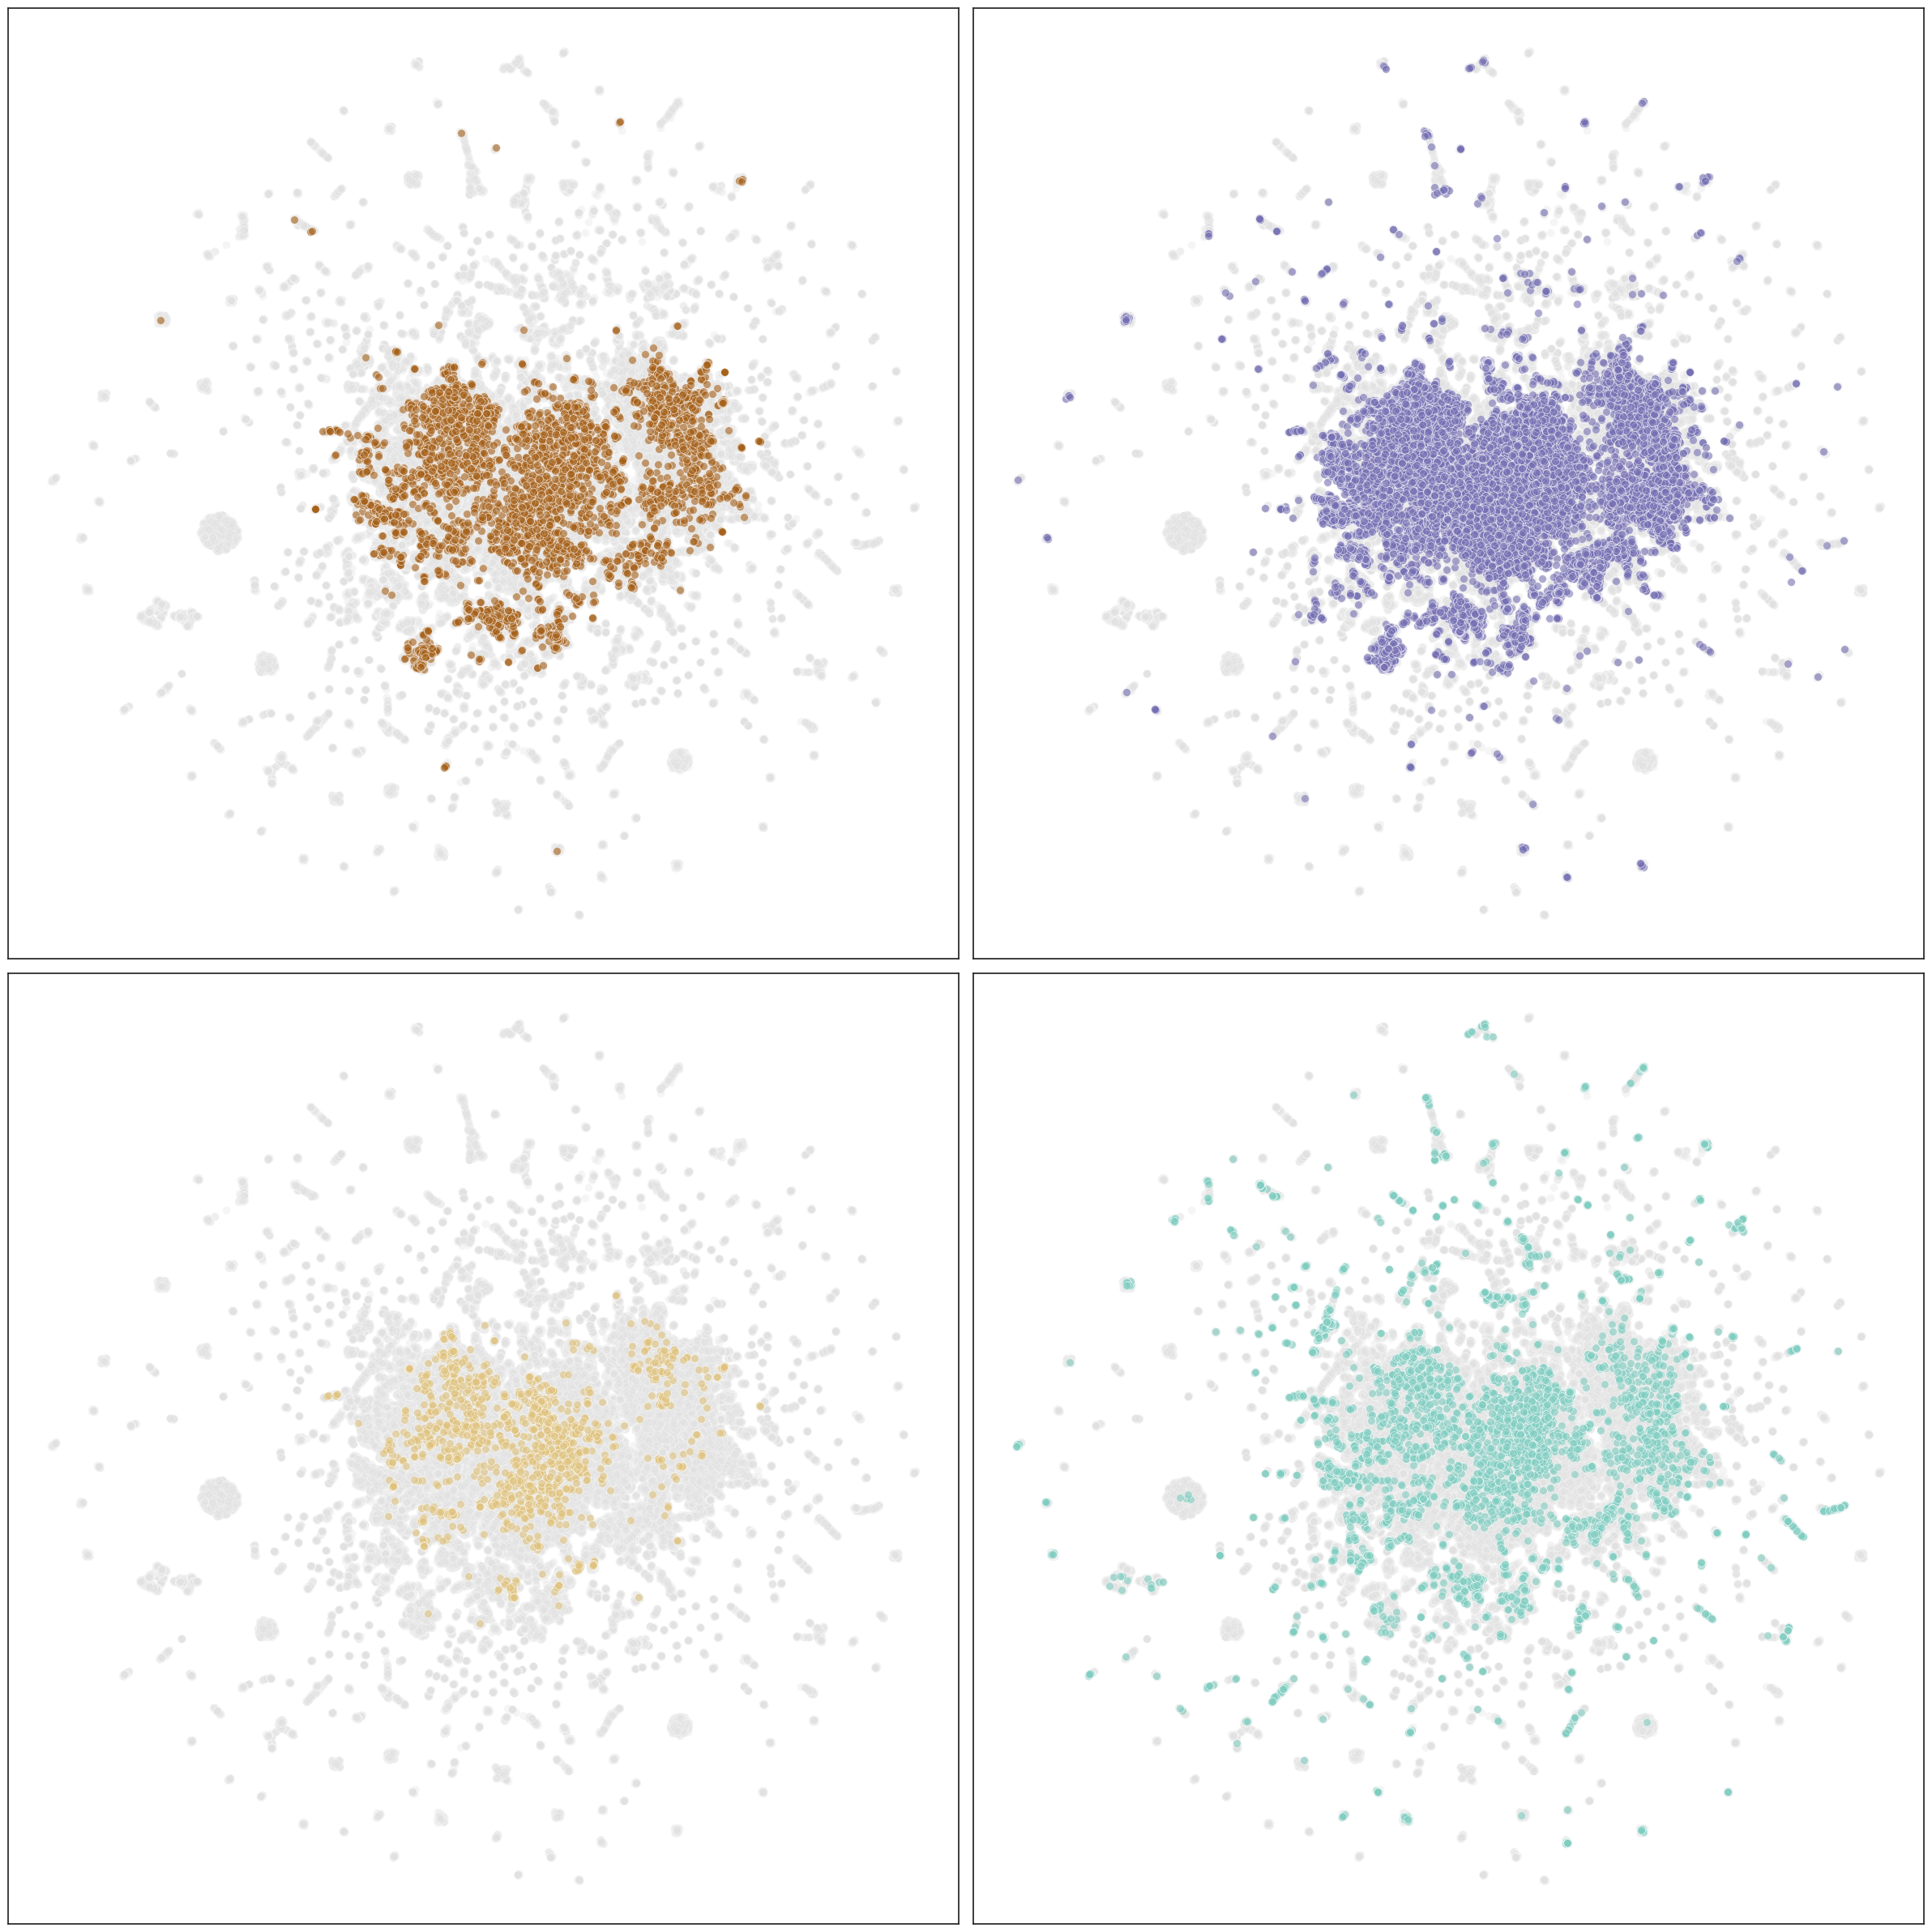

In [73]:
sns.set(font_scale=1)
sns.set_style("white")
fig, axes = plt.subplots(2, 2, figsize=(24, 24))
s=50

sns.scatterplot(x='x_axis', y='y_axis', data=pubchem_chemspace_final, color='#e1e1e1', ax=axes[0, 0], s=s, alpha=0.3)
sns.scatterplot(x='x_axis', y='y_axis', data=massbank_chemspace_final, color='#A6611A', ax=axes[0, 0], s=s, alpha=0.6)

sns.scatterplot(x='x_axis', y='y_axis', data=pubchem_chemspace_final, color='#e1e1e1', ax=axes[0, 1], s=s, alpha=0.3)
sns.scatterplot(x='x_axis', y='y_axis', data=sirius_chemspace_final, color='#7570B3', ax=axes[0, 1], s=s, alpha=0.6)


sns.scatterplot(x='x_axis', y='y_axis', data=pubchem_chemspace_final, color='#e1e1e1', ax=axes[1, 0], s=s, alpha=0.3)
sns.scatterplot(x='x_axis', y='y_axis', data=RTI_chemspace_final, color='#DFC27D', ax=axes[1, 0], s=s, alpha=0.6)

sns.scatterplot(x='x_axis', y='y_axis', data=pubchem_chemspace_final, color='#e1e1e1', ax=axes[1, 1], s=s, alpha=0.3)
sns.scatterplot(x='x_axis', y='y_axis', data=CCS_chemspace_final, color='#80CDC1', ax=axes[1, 1], s=s, alpha=0.6)

#handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, ['knowns: not selected', 'unknowns: not selected',  'knowns: selected', 'unknowns: selected'],
#           frameon=False, bbox_to_anchor=(0.4, 0.85))
#ax.get_legend().remove()
axes[0, 0].xaxis.set_tick_params(labelbottom=False)
axes[0, 0].yaxis.set_tick_params(labelleft=False)
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('')

axes[0, 1].xaxis.set_tick_params(labelbottom=False)
axes[0, 1].yaxis.set_tick_params(labelleft=False)
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')

axes[1, 0].xaxis.set_tick_params(labelbottom=False)
axes[1, 0].yaxis.set_tick_params(labelleft=False)
axes[1, 0].set_xticks([])
axes[1, 0].set_yticks([])
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('')

axes[1, 1].xaxis.set_tick_params(labelbottom=False)
axes[1, 1].yaxis.set_tick_params(labelleft=False)
axes[1, 1].set_xticks([])
axes[1, 1].set_yticks([])
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('')
plt.tight_layout()
plt.savefig('chemspaces_together.png', transparent=True, dpi=700)

#### Similarity of Candidate Structures

In [ ]:
# Reading the candidates file and converting the SIRIUS+CSI:FingerID fingerprints, where each fingerprint feature (bit) is in a different column, into a true bitvector.
candidates = pd.read_csv('path/to/the/file/that/contains/SIRIUS+CSI:FingerID/fingerprints/for/all/the/candidate/structures', sep='\t')
candidates['bitvector'] = candidates.iloc[:, ...:...].apply(lambda row: DataStructs.CreateFromBitString(''.join(row.values.astype(str))), axis=1)

In [82]:
candidates

,spectrum,SMILES,InChIKey14,source,bitvector
0,Candidate_163.0381,COc1ccccc1C(=O)O,ILUJQPXNXACGAN,MassBank,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ..."
1,Candidate_163.0381,COC(=O)c1ccccc1C(=O)OC,NIQCNGHVCWTJSM,MassBank,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Candidate_163.0381,CCN(CC)C(=O)c1ccccc1OC,ZFIIUAIWXACNKN,MassBank,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Candidate_163.0381,CCN(CC)C(=O)c1ccc(OC)cc1,HCJXEOFLVIFFDG,MassBank,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Candidate_163.0381,CCP(=O)(CC)CC,ZSSWXNPRLJLCDU,MassBank,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
519,Candidate_748.487,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(OC)C(C)O2)C(C)C(...,RBUYLURJQJPYPA,SIRIUS,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, ..."
520,Candidate_748.487,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,QMDNATNOGCONFR,SIRIUS,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, ..."
521,Candidate_748.487,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,ZBOWNNRNAIQDEF,SIRIUS,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, ..."
522,Candidate_748.487,CCCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(...,NHZVGFHCAIUQGB,SIRIUS,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, ..."


In [72]:
candidates.loc[:, ['MassBank', 'MetFrag', 'SIRIUS', 'Spec2Mol']].sum()

MassBank     86
MetFrag     198
SIRIUS      172
Spec2Mol     68
dtype: int64

Code used for calculating all the similarities

In [83]:
similarity_matrix = pd.DataFrame(index=candidates.SMILES.values, columns=candidates.SMILES.values)
avg_similarity = pd.DataFrame(columns=['spectrum1', 'spectrum2', 'source1', 'source2', 'average_similarity'], index=np.arange(6400))

seq1 = cycle(np.repeat(np.unique(candidates.spectrum.values), 16))
seq2 = cycle(np.repeat(np.unique(candidates.source.values), 4))
seq3 = cycle(np.unique(candidates.source.values))
avg_similarity['spectrum1'] = np.repeat(np.unique(candidates.spectrum.values), 320)
avg_similarity['spectrum2'] = [next(seq1) for count in range(avg_similarity.shape[0])]
avg_similarity['source1'] = [next(seq2) for count in range(avg_similarity.shape[0])]
avg_similarity['source2'] = [next(seq3) for count in range(avg_similarity.shape[0])]

for i in range(len(avg_similarity)):
    spectrum1 = avg_similarity.spectrum1[i]
    source1 = avg_similarity.source1[i]
    spectrum2 = avg_similarity.spectrum2[i]
    source2 = avg_similarity.source2[i]
    one = candidates[(candidates.spectrum == spectrum1) & (candidates.source == source1)].reset_index(drop=True)
    two = candidates[(candidates.spectrum == spectrum2) & (candidates.source == source2)].reset_index(drop=True)
    similarities = []
    for j in range(len(one)):
        first = one.bitvector[j]
        smiles1 = one.SMILES[j]
        for k in range(len(two)):    
            second = two.bitvector[k]
            smiles2 = two.SMILES[k]
            if source1 == source2 and spectrum1 == spectrum2 and smiles1 == smiles2:
                continue
            else:
                similarities.append(DataStructs.TanimotoSimilarity(first, second))
    avg_similarity.loc[i, 'average_similarity'] = np.average(similarities)

In [103]:
avg_similarity.sort_values(['source1', 'spectrum1', 'source2', 'spectrum2'])

,spectrum1,spectrum2,source1,source2,average_similarity
0,Candidate_163.0381,Candidate_163.0381,MassBank,MassBank,0.393950
16,Candidate_163.0381,Candidate_195.0875,MassBank,MassBank,0.151696
32,Candidate_163.0381,Candidate_198.9398,MassBank,MassBank,0.171330
48,Candidate_163.0381,Candidate_202.0855,MassBank,MassBank,0.121241
64,Candidate_163.0381,Candidate_216.1012,MassBank,MassBank,0.185261
...,...,...,...,...,...
6335,Candidate_748.487,Candidate_595.3495,Spec2Mol,Spec2Mol,NaN
6351,Candidate_748.487,Candidate_597.3648,Spec2Mol,Spec2Mol,NaN
6367,Candidate_748.487,Candidate_644.4951,Spec2Mol,Spec2Mol,NaN
6383,Candidate_748.487,Candidate_688.5216,Spec2Mol,Spec2Mol,NaN


In [117]:
trial_df = avg_similarity.sort_values(['source1', 'spectrum1', 'source2', 'spectrum2']).pivot(index=['source1', 'spectrum1'], columns=['source2', 'spectrum2'], values='average_similarity')

In [118]:
trial_df

source2                               MassBank                     \
spectrum2                   Candidate_163.0381 Candidate_195.0875   
source1  spectrum1                                                  
MassBank Candidate_163.0381           0.393950           0.151696   
         Candidate_195.0875           0.151696           0.983425   
         Candidate_198.9398           0.171330           0.084572   
         Candidate_202.0855           0.121241           0.225167   
         Candidate_216.1012           0.185261           0.197355   
...                                        ...                ...   
Spec2Mol Candidate_595.3495                NaN                NaN   
         Candidate_597.3648                NaN                NaN   
         Candidate_644.4951                NaN                NaN   
         Candidate_688.5216                NaN                NaN   
         Candidate_748.487                 NaN                NaN   

source2                                                            \
spectrum2                   Candidate_198.9398 Candidate_202.0855   
source1  spectrum1                                                  
MassBank Candidate_163.0381           0.171330           0.121241   
         Candidate_195.0875           0.084572           0.225167   
         Candidate_198.9398           0.524538           0.088308   
         Candidate_202.0855           0.088308                NaN   
         Candidate_216.1012           0.122753           0.528830   
...                                        ...                ...   
Spec2Mol Candidate_595.3495                NaN                NaN   
         Candidate_597.3648                NaN                NaN   
         Candidate_644.4951                NaN                NaN   
         Candidate_688.5216                NaN                NaN   
         Candidate_748.487                 NaN                NaN   

source2                                                            \
spectrum2                   Candidate_216.1012 Candidate_237.1026   
source1  spectrum1                                                  
MassBank Candidate_163.0381           0.185261           0.270631   
         Candidate_195.0875           0.197355           0.206037   
         Candidate_198.9398           0.122753           0.159723   
         Candidate_202.0855           0.528830           0.132026   
         Candidate_216.1012           0.196429           0.259335   
...                                        ...                ...   
Spec2Mol Candidate_595.3495                NaN                NaN   
         Candidate_597.3648                NaN                NaN   
         Candidate_644.4951                NaN                NaN   
         Candidate_688.5216                NaN                NaN   
         Candidate_748.487                 NaN                NaN   

source2                                                            \
spectrum2                   Candidate_284.1417 Candidate_297.0569   
source1  spectrum1                                                  
MassBank Candidate_163.0381           0.265635           0.212109   
         Candidate_195.0875           0.175080           0.240532   
         Candidate_198.9398           0.151361           0.141545   
         Candidate_202.0855           0.163148           0.194780   
         Candidate_216.1012           0.264000           0.238835   
...                                        ...                ...   
Spec2Mol Candidate_595.3495                NaN                NaN   
         Candidate_597.3648                NaN                NaN   
         Candidate_644.4951                NaN                NaN   
         Candidate_688.5216                NaN                NaN   
         Candidate_748.487                 NaN                NaN   

source2                                                            ...  \
spectrum2                   Candidate_315.2322 Candidate_3

In [183]:
sources = ['MassBank', 'MetFrag', 'SIRIUS', 'Spec2Mol']
for source1 in sources:
    for source2 in sources:
       avg = np.mean(avg_similarity[(avg_similarity.source1 == source1) & (avg_similarity.source2 == source2)].average_similarity)
       print(source1, source2, avg)

MassBank MassBank 0.2185358781791898
MassBank MetFrag 0.2147839972780123
MassBank SIRIUS 0.18474389830270788
MassBank Spec2Mol 0.25209299305293625
MetFrag MassBank 0.21478399727801228
MetFrag MetFrag 0.2539367794106676
MetFrag SIRIUS 0.19439083401369636
MetFrag Spec2Mol 0.24263340164495115
SIRIUS MassBank 0.18474389830270788
SIRIUS MetFrag 0.19439083401369636
SIRIUS SIRIUS 0.19695096982097604
SIRIUS Spec2Mol 0.19581978662066396
Spec2Mol MassBank 0.25209299305293625
Spec2Mol MetFrag 0.24263340164495117
Spec2Mol SIRIUS 0.19581978662066402
Spec2Mol Spec2Mol 0.40345923457111743


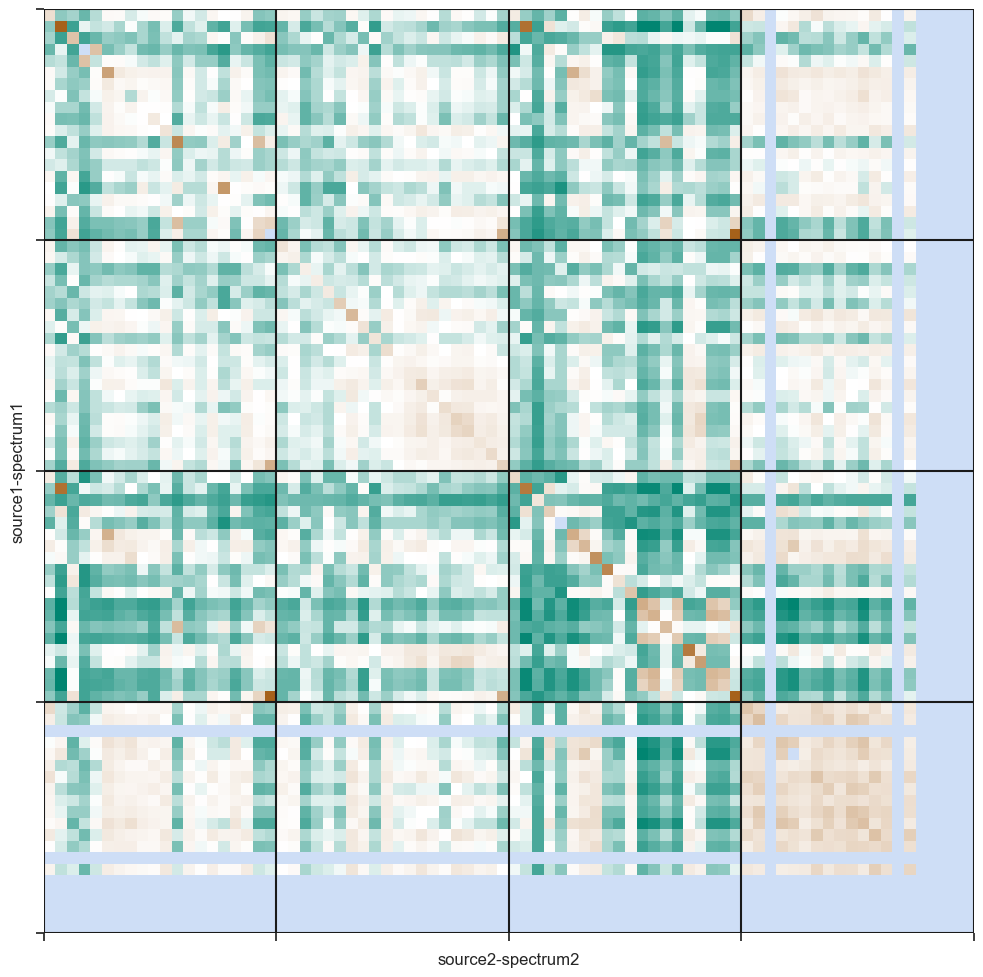

In [178]:
sns.set(font_scale=1)
sns.set_style("white", rc={
    'xtick.bottom': True,
    'ytick.left': True,
})
import matplotlib
#cmap = plt.colormaps.get_cmap('PiYG')
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', list(zip([0.0, np.mean(avg_similarity.average_similarity), 1.0], ['#018571', 'white', '#A6611A'])))
cmap.set_bad('#cedef6')
mask = trial_df.isnull()
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(data=trial_df, ax=ax, cmap=cmap, mask=mask, cbar=False)
ax.set_xticks(np.arange(0, 100, 20), labels=[])
ax.set_yticks(np.arange(0, 100, 20), labels=[])
ax.axhline(y=0, color='k',linewidth=1.5)
ax.axhline(y=20, color='k',linewidth=1.5)
ax.axhline(y=40, color='k',linewidth=1.5)
ax.axhline(y=60, color='k',linewidth=1.5)
ax.axhline(y=80, color='k',linewidth=1.5)

ax.axvline(x=0, color='k',linewidth=1.5)
ax.axvline(x=20, color='k',linewidth=1.5)
ax.axvline(x=40, color='k',linewidth=1.5)
ax.axvline(x=60, color='k',linewidth=1.5)
ax.axvline(x=80, color='k',linewidth=1.5)
#plt.show()
plt.savefig('first_corr.png', dpi=700)